In [113]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

import sys; sys.path.append('../..')
from utils.wandb_utils import get_wandb_project_table

In [114]:
api = wandb.Api()
# project = 'abstract_transformer--relational_games_learning_curves'
project = 'abstract_transformer--relational_games_learning_curves'

In [115]:
config_cols = ['d_model', 'n_layers', 'symbol_retrieval', 'n_heads_rca', 'n_heads_sa', 'rca_type', 'rca_kwargs.symmetric_rels', 'n_heads', 'task', 'train_size']
attr_cols = ['group', 'name']

project_df = get_wandb_project_table(
    project_name=project, entity='awni00', attr_cols=attr_cols, config_cols=config_cols, summary_cols='all')

In [116]:
project_df.head()

,group,name,_runtime,test/acc_in_distribution,test/loss_in_distribution,test/acc_hexos,_wandb,_timestamp,_step,test/loss_stripes,...,d_model,n_layers,symbol_retrieval,n_heads_rca,n_heads_sa,rca_type,rca_kwargs.symmetric_rels,n_heads,task,train_size
0,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,162.387316,0.7461,0.790650,0.68405,{'runtime': 161},1.715378e+09,0.0,2.399708,...,128,2,pos_sym_retriever,1.0,1.0,disentangled_v2,None,NaN,1task_match_patt,30000
1,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,161.452005,0.9616,0.180565,0.89900,{'runtime': 160},1.715378e+09,0.0,1.611184,...,128,2,pos_sym_retriever,1.0,1.0,disentangled_v2,None,NaN,1task_match_patt,27500
2,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,150.886259,0.7449,0.912223,0.67695,{'runtime': 149},1.715378e+09,0.0,2.494844,...,128,2,pos_sym_retriever,1.0,1.0,disentangled_v2,None,NaN,1task_match_patt,25000
3,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,142.877645,0.9105,0.355275,0.81195,{'runtime': 142},1.715378e+09,0.0,3.082216,...,128,2,pos_sym_retriever,1.0,1.0,disentangled_v2,None,NaN,1task_match_patt,22500
4,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,1task_match_patt__sa=1; rca=1; d=128; L=2; rca...,138.077277,0.7439,0.800453,0.68775,{'runtime': 136},1.715378e+09,0.0,2.328363,...,128,2,pos_sym_retriever,1.0,1.0,disentangled_v2,None,NaN,1task_match_patt,20000


In [117]:
def process_groupname(group_name):
    task, model_name = group_name.split('__')
    return model_name

In [118]:
project_df['model_name'] = project_df['group'].apply(process_groupname)

In [119]:
L, total_n_heads = 2, 2
filter_ = (project_df['n_layers'] == L) & ((project_df['n_heads_rca'] + project_df['n_heads_sa'] == total_n_heads) | (project_df['n_heads'] == total_n_heads)) & (project_df['train_size'] <= 25_000)
project_df_ = project_df[filter_]

In [120]:
project_df_.group.unique()

array(['1task_match_patt__sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       '1task_match_patt__sa=2; d=128; L=2',
       '1task_match_patt__sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       '1task_between__sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       'xoccurs__sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       'same__sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       '1task_between__sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       'same__sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       'xoccurs__sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
       'occurs__sa=

In [121]:
metric = 'test/acc_in_distribution'
agg_df = project_df_.groupby(['model_name', 'task', 'train_size'])[metric].aggregate(['mean', 'std', 'sem', 'count']).reset_index()
agg_df.rename(columns={'mean': 'Accuracy', 'sem': 'Standard Error', 'std': 'Standard Deviation', 'count': '# of Trials'}, inplace=True)
hover_data = ['# of Trials', 'Standard Deviation', 'Standard Error']
fig = px.line(
    agg_df, x='train_size', y='Accuracy', error_y='Standard Error', color='model_name', hover_data=hover_data, facet_col='task',
    facet_col_wrap=3, title=f'Learning curves ({metric})', width=1400, height=600)
fig.update_xaxes(matches=None)
fig.update_yaxes(showticklabels=True, col=1)
fig.update_yaxes(showticklabels=True, col=2)
fig.update_yaxes(showticklabels=True, col=3)
fig.update_xaxes(showticklabels=True, col=1)
fig.update_xaxes(showticklabels=True, col=2)
fig.update_xaxes(showticklabels=True, col=3)
fig.update_yaxes(matches=None)
fig.show()

In [122]:
metric = 'test/acc_hexos'
agg_df = project_df_.groupby(['model_name', 'task', 'train_size'])[metric].aggregate(['mean', 'std', 'sem', 'count']).reset_index()
agg_df.rename(columns={'mean': 'Accuracy', 'sem': 'Standard Error', 'std': 'Standard Deviation', 'count': '# of Trials'}, inplace=True)
hover_data = ['# of Trials', 'Standard Deviation', 'Standard Error']
fig = px.line(
    agg_df, x='train_size', y='Accuracy', error_y='Standard Error', color='model_name', hover_data=hover_data, facet_col='task',
    facet_col_wrap=3, title=f'Learning curves ({metric})', width=1400, height=600)
fig.update_xaxes(matches=None)
fig.update_yaxes(showticklabels=True, col=1)
fig.update_yaxes(showticklabels=True, col=2)
fig.update_yaxes(showticklabels=True, col=3)
fig.update_xaxes(showticklabels=True, col=1)
fig.update_xaxes(showticklabels=True, col=2)
fig.update_xaxes(showticklabels=True, col=3)
fig.update_yaxes(matches=None)
fig.show()

In [123]:
metric = 'test/acc_stripes'
agg_df = project_df_.groupby(['model_name', 'task', 'train_size'])[metric].aggregate(['mean', 'std', 'sem', 'count']).reset_index()
agg_df.rename(columns={'mean': 'Accuracy', 'sem': 'Standard Error', 'std': 'Standard Deviation', 'count': '# of Trials'}, inplace=True)
hover_data = ['# of Trials', 'Standard Deviation', 'Standard Error']
fig = px.line(
    agg_df, x='train_size', y='Accuracy', error_y='Standard Error', color='model_name', hover_data=hover_data, facet_col='task',
    facet_col_wrap=3, title=f'Learning curves ({metric})', width=1400, height=600)
fig.update_xaxes(matches=None)
fig.update_yaxes(showticklabels=True, col=1)
fig.update_yaxes(showticklabels=True, col=2)
fig.update_yaxes(showticklabels=True, col=3)
fig.update_xaxes(showticklabels=True, col=1)
fig.update_xaxes(showticklabels=True, col=2)
fig.update_xaxes(showticklabels=True, col=3)
fig.update_yaxes(matches=None)
fig.show()

/tmp/ipykernel_436787/3627558338.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/seaborn/

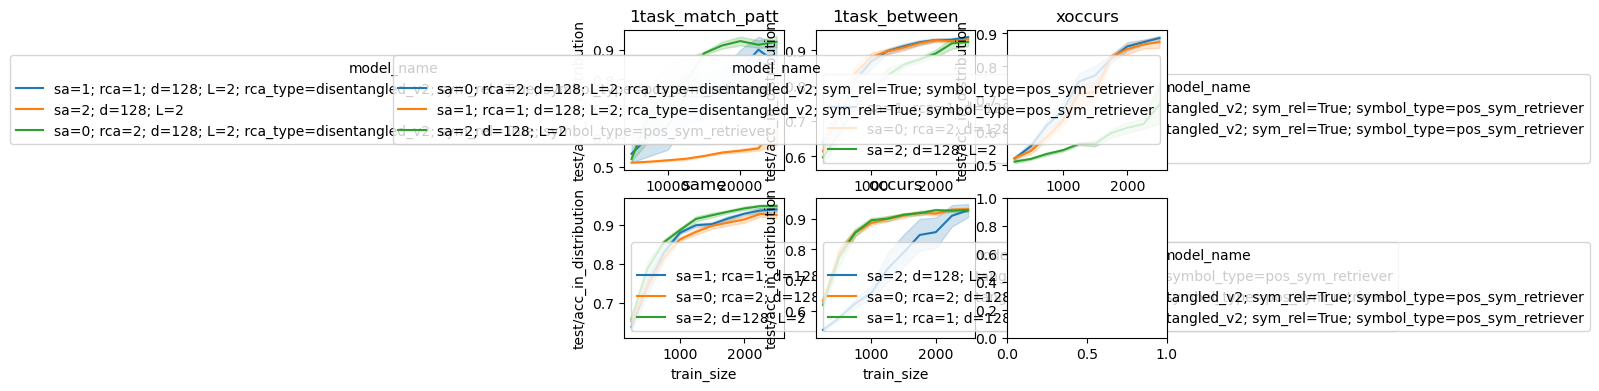

In [126]:
metric = 'test/acc_in_distribution'
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7, 4))
axs = axs.flatten()
for i, task in enumerate(project_df.task.unique()):
    task_df = project_df_[project_df.task == task]
    g = sns.lineplot(task_df, x='train_size', y=metric, hue='model_name', ax=axs[i], )
    g.set_title(task)
    # sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.5))